# Score: 0.784

<a id="toc"></a>

# <u>Table of Contents</u>
1.) [TODO](#todo)  
2.) [Imports](#imports)  
3.) [Data path](#path)  
4.) [Bureau](#bureau)  
5.) [Bureau Balance](#bureau_bal)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.1.) [Merge into Bureau](#merge_bureau_bal)  
6.) [Previous Application](#prev_app)  
7.) [POS CASH balance](#pos_cash)  
&nbsp;&nbsp;&nbsp;&nbsp; 7.1.) [Missing values](#pos_nan)  
&nbsp;&nbsp;&nbsp;&nbsp; 7.2.) [Merge into Previous Application](#merge_pos_cash)  
8.) [Installment Payments](#install_pay)  
&nbsp;&nbsp;&nbsp;&nbsp; 8.1.) [Missing values](#install_nan)  
&nbsp;&nbsp;&nbsp;&nbsp; 8.2.) [Merge into Previous Application](#merge_install_pay)  
9.) [Credit Card Balance](#credit)  
&nbsp;&nbsp;&nbsp;&nbsp; 9.1.) [Missing values](#credit_nan)  
&nbsp;&nbsp;&nbsp;&nbsp; 9.2.) [Merge into Previous Application](#merge_credit)  
10.) [Miscellaneous Clean Up](#clean_up)  
11.) [Final Data Prep](#final_merge)   
&nbsp;&nbsp;&nbsp;&nbsp; 11.1.) [Missing values](#final_nan)  
&nbsp;&nbsp;&nbsp;&nbsp; 11.2.) [Merge Previous Application with Full](#merge_prev)  
&nbsp;&nbsp;&nbsp;&nbsp; 11.3.) [Merge Bureau with Full](#merge_bureau)  
12.) [Modeling](#models)  
13.) [Save file to CSV](#save)  

<a id="todo"></a>

# [^](#toc) <u>TODO</u>

- Fix skew on columns
- Instead of col for NaN value increment shared column
- Tinker with the best way to replace missing values (dropping cols?)
- Look for outliers
- Include timeline relatoinships like MONTHS_BALANCE
- Tune model parameters
- Average 5 folds in submission
- Use feature importance to drop or improve features
- Address [this](https://www.kaggle.com/c/home-credit-default-risk/discussion/57750) - feature engineering comment
- Feature engineering kernel ([link](https://www.kaggle.com/shanth84/credit-card-balance-feature-engineering))
- Address [this](https://www.kaggle.com/c/home-credit-default-risk/discussion/57248) - (XNA/XAP and 365243)

---
<a id="imports"></a>

# [^](#toc) <u>Imports</u>

In [43]:
### Standard imports
import pandas as pd
import numpy as np

# Time keeper
import time

# Garbage collector
import gc

# Progress bar
from tqdm import tqdm

### Removes warnings from output
import warnings
warnings.filterwarnings('ignore')

### Helper functions

In [44]:
# function to create dummy variables of categorical features
def get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

def fillna_num(df):
    missing_cols = [col for col in df.columns if any(df[col].isnull()) and df[col].dtype != object]
    for col in missing_cols:
        df[col] = df[col].fillna(df[col].median())
    return df

def fillna_cat(df):
    for col in [col for col in df if df[col].dtype==object]:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df

def factorize_df(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

---
<a id="path"></a>

# [^](#toc) <u>Data path</u>

In [3]:
DATA_PATH = "../data/home_default/"

---
<a id="bureau"></a>

# [^](#toc) <u>Bureau</u>

In [4]:
bureau   = pd.read_csv(DATA_PATH + "bureau.csv")
print("Shape of bureau:", bureau.shape)

print("\nColumns of bureau:")
print(" --- ".join(bureau.columns.values))

Shape of bureau: (1716428, 17)

Columns of bureau:
SK_ID_CURR --- SK_ID_BUREAU --- CREDIT_ACTIVE --- CREDIT_CURRENCY --- DAYS_CREDIT --- CREDIT_DAY_OVERDUE --- DAYS_CREDIT_ENDDATE --- DAYS_ENDDATE_FACT --- AMT_CREDIT_MAX_OVERDUE --- CNT_CREDIT_PROLONG --- AMT_CREDIT_SUM --- AMT_CREDIT_SUM_DEBT --- AMT_CREDIT_SUM_LIMIT --- AMT_CREDIT_SUM_OVERDUE --- CREDIT_TYPE --- DAYS_CREDIT_UPDATE --- AMT_ANNUITY


### Lump together values with low counts

In [5]:
# CREDIT_CURRENCY
# cols = ["currency 3", "currency 4"]
# bureau.CREDIT_CURRENCY = bureau.CREDIT_CURRENCY.map(lambda x: "MISC" if x in cols else x)

# CREDIT_TYPE
cols = ["Loan for purchase of shares (margin lending)", "Interbank credit", "Mobile operator loan"]
bureau = bureau.drop(bureau[bureau.CREDIT_TYPE.isin(cols)].index)

### Missing Values

In [6]:
# bureau   = fillna_num(bureau)
# bureau   = fillna_cat(bureau)

cols = ["DAYS_CREDIT_ENDDATE", "DAYS_ENDDATE_FACT", "AMT_CREDIT_MAX_OVERDUE",
        "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT",
        "AMT_ANNUITY"]

bureau["nan"] = np.zeros(len(bureau)).astype(int)
for col in tqdm(cols):
    bureau["nan"] += bureau[col].map(lambda x: 1 if np.isnan(x) else 0)
    temp           = bureau[bureau[col].notnull()][col].mode()
    bureau[col]    = bureau[col].fillna(temp)
    
sum(bureau.isnull().sum())

100%|██████████| 7/7 [00:19<00:00,  2.78s/it]


3939924

<a id="bureau_bal"></a>

# [^](#toc) <u>Bureau Balance</u>

In [7]:
bureau_balance = pd.read_csv(DATA_PATH + "bureau_balance.csv")
print("Shape of bureau_balance:",  bureau_balance.shape)

print("\nColumns of bureau_balance:")
print(" --- ".join(bureau_balance.columns.values))

Shape of bureau_balance: (27299925, 3)

Columns of bureau_balance:
SK_ID_BUREAU --- MONTHS_BALANCE --- STATUS


<a id="merge_bureau_bal"></a>

### [^](#toc) <u>Merge into Bureau</u>

In [8]:
merge_df = get_dummies(bureau_balance, ["STATUS"])
merge_df = merge_df.drop(["MONTHS_BALANCE", "STATUS"], axis=1)

# prep for merge
merge_df = merge_df.groupby("SK_ID_BUREAU").sum().reset_index()

### Add the median of the rest of the columns
right    = bureau_balance.groupby("SK_ID_BUREAU").median().reset_index()
merge_df = merge_df.merge(right=right, how="left", on="SK_ID_BUREAU").set_index("SK_ID_BUREAU")

### Remember added columns
merged_cols = ['bur_bal_' + col for col in merge_df.columns]
merge_df.columns = merged_cols

# Merge
bureau = bureau.merge(right=merge_df.reset_index(), how='left', on='SK_ID_BUREAU')

### Fill in new missing values

In [9]:
bureau["no_bureau_bal"] = bureau[merged_cols[0]].map(lambda x: 1 if np.isnan(x) else 0)
bureau[merged_cols]     = bureau[merged_cols].fillna(0)

# Delete old variables
del bureau_balance, merge_df, merged_cols, right
gc.collect()

# Make sure missing values were filled in
sum(bureau.isnull().sum())

3939924

---
<a id="prev_app"></a>

# [^](#toc) <u>Previous Application</u>

In [10]:
prev_app = pd.read_csv(DATA_PATH + "previous_application.csv")
print("Shape of prev_app:",  prev_app.shape)

print("\nColumns of prev_app:")
print(" --- ".join(prev_app.columns.values))

Shape of prev_app: (1670214, 37)

Columns of prev_app:
SK_ID_PREV --- SK_ID_CURR --- NAME_CONTRACT_TYPE --- AMT_ANNUITY --- AMT_APPLICATION --- AMT_CREDIT --- AMT_DOWN_PAYMENT --- AMT_GOODS_PRICE --- WEEKDAY_APPR_PROCESS_START --- HOUR_APPR_PROCESS_START --- FLAG_LAST_APPL_PER_CONTRACT --- NFLAG_LAST_APPL_IN_DAY --- RATE_DOWN_PAYMENT --- RATE_INTEREST_PRIMARY --- RATE_INTEREST_PRIVILEGED --- NAME_CASH_LOAN_PURPOSE --- NAME_CONTRACT_STATUS --- DAYS_DECISION --- NAME_PAYMENT_TYPE --- CODE_REJECT_REASON --- NAME_TYPE_SUITE --- NAME_CLIENT_TYPE --- NAME_GOODS_CATEGORY --- NAME_PORTFOLIO --- NAME_PRODUCT_TYPE --- CHANNEL_TYPE --- SELLERPLACE_AREA --- NAME_SELLER_INDUSTRY --- CNT_PAYMENT --- NAME_YIELD_GROUP --- PRODUCT_COMBINATION --- DAYS_FIRST_DRAWING --- DAYS_FIRST_DUE --- DAYS_LAST_DUE_1ST_VERSION --- DAYS_LAST_DUE --- DAYS_TERMINATION --- NFLAG_INSURED_ON_APPROVAL


### Lump together values with low counts

In [11]:
# # NAME_GOODS_CATEGORY
# prev_app.NAME_GOODS_CATEGORY = prev_app.NAME_GOODS_CATEGORY.map(
#     lambda x: "MISC" if x in ["Weapon", "Insurance"] else x)

# # NAME_CASH_LOAN_PURPOSE
# prev_app.NAME_CASH_LOAN_PURPOSE = prev_app.NAME_CASH_LOAN_PURPOSE.map(
#     lambda x: "MISC" if x in ["Hobby", "Money for a third person", "Refusal to name the goal"] else x)

### Missing values

In [12]:
# prev_app = fillna_num(prev_app)
# prev_app = fillna_cat(prev_app)

# prev_app["nan"] = np.zeros(len(prev_app)).astype(int)

# ### Fillin missing values with filler... NaN
# for col in ("NAME_TYPE_SUITE", "PRODUCT_COMBINATION"):
#     prev_app["nan"] += prev_app[col].map(lambda x: 1 if type(x) == float else 0)
#     prev_app[col]    = prev_app[col].fillna("NaN")

### Drop outliers
prev_app = prev_app.drop(
                            prev_app[(prev_app.NAME_GOODS_CATEGORY == "Animals") |
                                     (prev_app.NAME_GOODS_CATEGORY == "House Construction")].index)

### Light missing values
prev_app["AMT_CREDIT"] = prev_app["AMT_CREDIT"].fillna(prev_app["AMT_CREDIT"].median())

### Moderate missing values
for col in tqdm(("AMT_ANNUITY", "AMT_GOODS_PRICE", "CNT_PAYMENT", "AMT_DOWN_PAYMENT", "RATE_DOWN_PAYMENT",
                "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE",
                "DAYS_TERMINATION", "NFLAG_INSURED_ON_APPROVAL")):
#     prev_app["nan"] += prev_app[col].map(lambda x: 1 if np.isnan(x) else 0)
    prev_app[col]    = prev_app[col].transform(lambda x: x.fillna(x.median()))
    
### Severe missing values
for col in ("RATE_INTEREST_PRIMARY", "RATE_INTEREST_PRIVILEGED"):
#     prev_app["nan"] += prev_app[col].map(lambda x: 1 if np.isnan(x) else 0)
    prev_app[col]    = prev_app[col].transform(lambda x: x.fillna(x.median()))
#     prev_app[col] = prev_app[col].map(lambda x: 0 if np.isnan(x) else x)
    
sum(prev_app.isnull().sum())

100%|██████████| 11/11 [00:27<00:00,  2.48s/it]


0

---
<a id="pos_cash"></a>

# [^](#toc) <u>POS CASH balance</u>

In [13]:
pcb = pd.read_csv(DATA_PATH + "POS_CASH_balance.csv")
print("Shape of pcb:",  pcb.shape)

print("\nColumns of pcb:")
print(" --- ".join(pcb.columns.values))

Shape of pcb: (10001358, 8)

Columns of pcb:
SK_ID_PREV --- SK_ID_CURR --- MONTHS_BALANCE --- CNT_INSTALMENT --- CNT_INSTALMENT_FUTURE --- NAME_CONTRACT_STATUS --- SK_DPD --- SK_DPD_DEF


<a id="pos_nan"></a>

### [^](#toc) Data processing

In [14]:
pcb["nan"] = np.zeros(len(pcb)).astype(int)

# Fill in missing values
for col in ("CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE"):
    pcb["nan"] += pcb[col].map(lambda x: 1 if np.isnan(x) else 0)
    pcb[col]    = pcb[col].transform(lambda x: x.fillna(x.median()))
    
# Remove Outliers
pcb = pcb.drop(pcb[pcb.NAME_CONTRACT_STATUS.isin(["XNA", "Canceled"])].index)

### Get Dummies

In [15]:
merge_df = pcb[["SK_ID_PREV", "NAME_CONTRACT_STATUS"]]

merge_df = get_dummies(merge_df, ["NAME_CONTRACT_STATUS"])
merge_df = merge_df.drop("NAME_CONTRACT_STATUS", axis=1)

<a id="merge_pos_cash"></a>

### [^](#toc) <u>Merge into Previous Application</u>

In [16]:
# prep for merge
count    = merge_df.groupby("SK_ID_PREV").count()
merge_df = merge_df.groupby("SK_ID_PREV").sum().reset_index()
merge_df["N"] = list(count.iloc[:,0])

right    = pcb.drop(["SK_ID_CURR", "nan", "NAME_CONTRACT_STATUS"], axis=1).groupby("SK_ID_PREV").median().reset_index()
merge_df = merge_df.merge(right=right, how="left", on="SK_ID_PREV").set_index("SK_ID_PREV")

# Sum missing values
merge_df["nan"] = pcb.groupby("SK_ID_PREV")["nan"].sum()

merged_cols = ['pos_' + col for col in merge_df.columns]
merge_df.columns = merged_cols

# Merge
prev_app = prev_app.merge(right=merge_df.reset_index(), how='left', on='SK_ID_PREV')

### Fill in missing values

In [17]:
prev_app["no_pcb"] = prev_app[merged_cols[0]].map(lambda x: 1 if np.isnan(x) else 0)

for col in tqdm(merged_cols):
    not_null      = prev_app[col].notnull()
    temp          = prev_app[not_null][col].mode()
    prev_app[col] = prev_app[col].fillna(temp)    
    
# Delete old variables
del pcb, merge_df, merged_cols, right, count
gc.collect()

# Make sure missing values were filled in
sum(prev_app.isnull().sum())

100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


10798354

---
<a id="install_pay"></a>

# [^](#toc) <u>Installment Payments</u>

In [18]:
install_pay = pd.read_csv(DATA_PATH + "installments_payments.csv")
print("Shape of install_pay:",  install_pay.shape)

print("\nColumns of install_pay:")
print(" --- ".join(install_pay.columns.values))

Shape of install_pay: (13605401, 8)

Columns of install_pay:
SK_ID_PREV --- SK_ID_CURR --- NUM_INSTALMENT_VERSION --- NUM_INSTALMENT_NUMBER --- DAYS_INSTALMENT --- DAYS_ENTRY_PAYMENT --- AMT_INSTALMENT --- AMT_PAYMENT


<a id="install_nan"></a>

### [^](#toc) <u>Missing values</u>

In [19]:
install_pay["nan"] = np.zeros(len(install_pay)).astype(int)

for col in ("DAYS_ENTRY_PAYMENT", "AMT_PAYMENT"):
    install_pay["nan"] = install_pay[col].map(lambda x: 1 if np.isnan(x) else 0)
    install_pay[col]   = install_pay[col].fillna(0)

### Setup for merge

In [20]:
install_pay["AMT_MISSING"] = install_pay["AMT_INSTALMENT"] - install_pay["AMT_PAYMENT"]
temp = install_pay.groupby("SK_ID_PREV")["AMT_MISSING"]

merge_df = pd.DataFrame({
    "missing_max": temp.max(),
    "missing_min": temp.min(),
    "missing_med": temp.median(),
    "nan":         install_pay.groupby("SK_ID_PREV")["nan"].sum(),
    "N":           temp.count()
})

<a id="merge_install_pay"></a>

### [^](#toc) <u>Merge into Previous Application</u>

In [21]:
right = install_pay.drop(["SK_ID_CURR", "nan"], axis=1).groupby("SK_ID_PREV").median().reset_index()
merge_df = merge_df.reset_index()

merge_df = merge_df.merge(right=right, how="left", on="SK_ID_PREV").set_index("SK_ID_PREV")

merged_cols = ['install_' + col for col in merge_df.columns]
merge_df.columns = merged_cols

# Merge
prev_app = prev_app.merge(right=merge_df.reset_index(), how='left', on='SK_ID_PREV')

### Fill in missing values

In [22]:
prev_app["no_install"] = prev_app[merged_cols[0]].map(lambda x: 1 if np.isnan(x) else 0)

for col in tqdm(merged_cols):
    not_null      = prev_app[col].notnull()
    temp          = prev_app[not_null][col].mode()
    prev_app[col] = prev_app[col].fillna(temp)    
    
# Delete old variables
del install_pay, merge_df, merged_cols, right, temp
gc.collect()

# Make sure missing values were filled in
sum(prev_app.isnull().sum())

100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


19334050

---
<a id="credit"></a>

# [^](#toc) <u>Credit Card Balance</u>

In [23]:
credit_card = pd.read_csv(DATA_PATH + "credit_card_balance.csv")
print("Shape of credit_card:",  credit_card.shape)

print("\nColumns of credit_card:")
print(" --- ".join(credit_card.columns.values))

Shape of credit_card: (3840312, 23)

Columns of credit_card:
SK_ID_PREV --- SK_ID_CURR --- MONTHS_BALANCE --- AMT_BALANCE --- AMT_CREDIT_LIMIT_ACTUAL --- AMT_DRAWINGS_ATM_CURRENT --- AMT_DRAWINGS_CURRENT --- AMT_DRAWINGS_OTHER_CURRENT --- AMT_DRAWINGS_POS_CURRENT --- AMT_INST_MIN_REGULARITY --- AMT_PAYMENT_CURRENT --- AMT_PAYMENT_TOTAL_CURRENT --- AMT_RECEIVABLE_PRINCIPAL --- AMT_RECIVABLE --- AMT_TOTAL_RECEIVABLE --- CNT_DRAWINGS_ATM_CURRENT --- CNT_DRAWINGS_CURRENT --- CNT_DRAWINGS_OTHER_CURRENT --- CNT_DRAWINGS_POS_CURRENT --- CNT_INSTALMENT_MATURE_CUM --- NAME_CONTRACT_STATUS --- SK_DPD --- SK_DPD_DEF


<a id="credit_nan"></a>

### [^](#toc) <u>Missing Values and Outliers</u>

In [24]:
# ------------------------------
### Remove outliers
# Gets indices with outlier values
temp = credit_card[credit_card.NAME_CONTRACT_STATUS.isin(["Refused", "Approved"])].index

# Drops outlier values
credit_card = credit_card.drop(temp, axis=0)

# ------------------------------
#### Fill in missing values
cols = [
        "AMT_DRAWINGS_ATM_CURRENT", "AMT_DRAWINGS_OTHER_CURRENT", "AMT_DRAWINGS_POS_CURRENT", 
        "AMT_INST_MIN_REGULARITY", "AMT_PAYMENT_CURRENT", "CNT_DRAWINGS_ATM_CURRENT", 
        "CNT_DRAWINGS_OTHER_CURRENT", "CNT_DRAWINGS_POS_CURRENT", "CNT_INSTALMENT_MATURE_CUM"
]

credit_card["nan"] = np.zeros(len(credit_card)).astype(int)

for col in tqdm(cols):
    credit_card["nan"] += credit_card[col].map(lambda x: 1 if np.isnan(x) else 0)
    not_null = credit_card[col].notnull()
    temp = credit_card[not_null][col].mode()
    credit_card[col] = credit_card[col].fillna(temp)
    
sum(credit_card.isnull().sum())

100%|██████████| 9/9 [00:55<00:00,  6.16s/it]


5877179

<a id="merge_credit"></a>

### [^](#toc) <u>Merge into Previous Application</u>

In [25]:
### Select numeric columns
merge_df = pd.DataFrame({
    "max_SK_DPD":     credit_card.groupby("SK_ID_PREV").SK_DPD.max(),
    "max_SK_DPD_DEF": credit_card.groupby("SK_ID_PREV").SK_DPD_DEF.max(),
    "nan":            credit_card.groupby("SK_ID_PREV").nan.sum(),
    "N":              credit_card.groupby("SK_ID_PREV").count().iloc[:,0]
})

### Select categoric columns
temp = credit_card[["SK_ID_PREV", "NAME_CONTRACT_STATUS"]]
temp = get_dummies(temp, ["NAME_CONTRACT_STATUS"])
temp = temp.drop("NAME_CONTRACT_STATUS", axis=1)
temp = temp.groupby("SK_ID_PREV").sum()

### Merge both
merge_df = temp.join(merge_df)

### Add the rest of the columns
right = credit_card.drop(["SK_ID_CURR", "nan", "NAME_CONTRACT_STATUS"], axis=1).groupby("SK_ID_PREV").median().reset_index()
merge_df = merge_df.reset_index()
merge_df = merge_df.merge(right=right, how="left", on="SK_ID_PREV").set_index("SK_ID_PREV")

# Merge
merged_cols = ['credit_' + col for col in merge_df.columns]
merge_df.columns = merged_cols
prev_app = prev_app.merge(right=merge_df.reset_index(), how='left', on='SK_ID_PREV')

### Fill in new NaN values

In [26]:
prev_app["no_credit"] = prev_app[merged_cols[0]].map(lambda x: 1 if np.isnan(x) else 0)

for col in tqdm(merged_cols):
    not_null = prev_app[col].notnull()
    temp = prev_app[not_null][col].mode()
    prev_app[col] = prev_app[col].fillna(temp)    
    
# Delete old variables
del credit_card, merge_df, merged_cols, right, temp
gc.collect()

# Make sure missing values were filled in
sum(prev_app.isnull().sum())

100%|██████████| 29/29 [00:07<00:00,  4.12it/s]


65290215

---
<a id="clean_up"></a>

# [^](#toc) <u>Miscellaneous Clean Up</u>

In [27]:
### Drop unneeded ID columns
prev_app = prev_app.drop("SK_ID_PREV", axis=1)
bureau   = bureau.drop("SK_ID_BUREAU", axis=1)

print("Number of null in prev_app:", sum(prev_app.isnull().sum()))
print("Number of null in bureau:  ", sum(bureau.isnull().sum()))

Number of null in prev_app: 65290215
Number of null in bureau:   3939924


---
<a id="final_merge"></a>

# [^](#toc) <u>Final Data Prep</u>

In [28]:
train = pd.read_csv(DATA_PATH + "train.csv")
test  = pd.read_csv(DATA_PATH + "test.csv")

print("Shape of train:", train.shape)
print("Shape of test: ", test.shape)

Shape of train: (307511, 122)
Shape of test:  (48744, 121)


### Data Preprocessing

In [29]:
### Split into predictors, target, and id
train_y = train.TARGET
train_x = train.drop(["TARGET"], axis=1)
test_id = test.SK_ID_CURR
test_x  = test

### Merge train and test data
full    = pd.concat([train_x, test_x])
train_N = len(train_x)

del train, test
gc.collect()

34

<a id="final_nan"></a>

### [^](#toc) <u>Missing values</u>

In [30]:
full["nan"]  = np.zeros(len(full)).astype(int)

# ------------ Categorical columns ------------ #
### Severe missing
for col in ("OCCUPATION_TYPE", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE"):
    full["nan"] += full[col].map(lambda x: 1 if type(x) == float else 0)
    full[col]    = full[col].fillna("NaN")

### Low missing
full["nan"]            += full["NAME_TYPE_SUITE"].map(lambda x: 1 if type(x) == float else 0)
full["NAME_TYPE_SUITE"] = full["NAME_TYPE_SUITE"].fillna("Unaccompanied")

### Quasi missing
full["nan"]        += full["CODE_GENDER"].map(lambda x:  1  if x == "XNA" else 0)
full["CODE_GENDER"] = full["CODE_GENDER"].map(lambda x: "F" if x == "XNA" else x)

full["nan"]               += full["NAME_FAMILY_STATUS"].map(lambda x: 1 if x == "Unknown" else 0)
full["NAME_FAMILY_STATUS"] = full["NAME_FAMILY_STATUS"].map(lambda x: "Married" if x == "Unknown" else x)

# NAME_INCOME_TYPE
cols = ["Unemployed", "Student", "Businessman", "Maternity leave"]
full["NAME_INCOME_TYPE"] = full["NAME_INCOME_TYPE"].map(lambda x: "MISC" if x in cols else x)

### ORGANIZATION_TYPE
cols = ["Trade: type 4", "Trade: type 5"]
full["ORGANIZATION_TYPE"] = full["ORGANIZATION_TYPE"].map(lambda x: "MISC Trade" if x in cols else x)
cols = ["Industry: type 13", "Industry: type 8"]
full["ORGANIZATION_TYPE"] = full["ORGANIZATION_TYPE"].map(lambda x: "MISC Industry" if x in cols else x)

# -------------- Numeric columns -------------- #
cols = [col for col in full.columns if any(full[col].isnull()) and full[col].dtype != object]
for col in cols:
    full["nan"] += full[col].map(lambda x: 1 if np.isnan(x) else 0)
    full[col]    = full[col].fillna(full[col].median())

# full = fillna_cat(full)
# full = fillna_num(full)
sum(full.isnull().sum())

0

### Factorize

Don't factorize?

In [31]:
# Get categorical features
data_cats = [col for col in full.columns if full[col].dtype == 'object']

# Factorize the dataframe
full = factorize_df(full, data_cats)

<a id="merge_prev"></a>

### [^](#toc) Merge Previous Application with Full

In [33]:
cat_cols = [
        "NAME_CONTRACT_TYPE", "WEEKDAY_APPR_PROCESS_START",
        "FLAG_LAST_APPL_PER_CONTRACT", "NAME_CASH_LOAN_PURPOSE",
        "NAME_CONTRACT_STATUS", "NAME_PAYMENT_TYPE",
        "CODE_REJECT_REASON", "NAME_TYPE_SUITE", "NAME_CLIENT_TYPE",
        "NAME_GOODS_CATEGORY", "NAME_PORTFOLIO", "NAME_PRODUCT_TYPE",
        "CHANNEL_TYPE", "NAME_SELLER_INDUSTRY", "NAME_YIELD_GROUP",
        "PRODUCT_COMBINATION", "SK_ID_CURR"]

# sum_cols = ['nan', 'pos_N', 'pos_nan', 'no_pcb', 'install_N', 'install_nan', 'no_install', 
#             'credit_N', 'credit_nan', 'no_credit', 'pos_NAME_CONTRACT_STATUS_Active',  
#             'pos_NAME_CONTRACT_STATUS_Amortized debt', 'pos_NAME_CONTRACT_STATUS_Approved',
#             'pos_NAME_CONTRACT_STATUS_Completed', 'pos_NAME_CONTRACT_STATUS_Demand', 
#             'pos_NAME_CONTRACT_STATUS_Returned to the store', 'pos_NAME_CONTRACT_STATUS_Signed',
#             'credit_NAME_CONTRACT_STATUS_Active', 'credit_NAME_CONTRACT_STATUS_Completed',
#             'credit_NAME_CONTRACT_STATUS_Demand', 'credit_NAME_CONTRACT_STATUS_Sent proposal',
#             'credit_NAME_CONTRACT_STATUS_Signed', "SK_ID_CURR"]

# max_cols = []

num_cols = [col for col in prev_app.columns if col not in cat_cols]# and col not in sum_cols]
num_cols.append("SK_ID_CURR")

# Numeric columns
merge_df      = prev_app[num_cols].groupby('SK_ID_CURR').median()
merge_df["N"] = prev_app.groupby('SK_ID_CURR').count().iloc[:,0]

# Categorical columns
right = prev_app[cat_cols].set_index("SK_ID_CURR")
right = pd.get_dummies(right).reset_index()
right = right.groupby("SK_ID_CURR").sum().reset_index()

### Merge numeric with categorical
merge_df = merge_df.reset_index()
merge_df = merge_df.merge(right=right, how="left", on="SK_ID_CURR").set_index("SK_ID_CURR")

# ### Summation columns
# right = prev_app[sum_cols].set_index("SK_ID_CURR")
# right = right.groupby("SK_ID_CURR").sum().reset_index()

# ### Merge with rest
# merge_df = merge_df.reset_index()
# merge_df = merge_df.merge(right=right, how="left", on="SK_ID_CURR").set_index("SK_ID_CURR")

merged_cols   = ['p_' + col for col in merge_df.columns]
merge_df.columns = merged_cols

full = full.merge(right=merge_df.reset_index(), how='left', on='SK_ID_CURR')

#### Fill NaN values

In [34]:
full["no_prev_app"] = full[merged_cols[0]].map(lambda x: 1 if np.isnan(x) else 0)

for col in tqdm(merged_cols):
    not_null  = full[col].notnull()
    temp      = full[not_null][col].mode()
    full[col] = full[col].fillna(temp)    
    
sum(full.isnull().sum())

100%|██████████| 222/222 [02:47<00:00,  1.33it/s]


11307294

<a id="merge_bureau"></a>

### [^](#toc) Merge Bureau with Full

In [35]:
cat_cols = ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE', 'SK_ID_CURR']
# sum_cols = ["nan", 'bur_bal_STATUS_0', 'bur_bal_STATUS_1', 'bur_bal_STATUS_2', 
#             'bur_bal_STATUS_3', 'bur_bal_STATUS_4', 'bur_bal_STATUS_5',
#             'bur_bal_STATUS_C',  'bur_bal_STATUS_X', 'no_bureau_bal', "SK_ID_CURR"]

num_cols = [col for col in bureau.columns if col not in cat_cols]# and col not in sum_cols]
num_cols.append("SK_ID_CURR")

# Numeric columns
merge_df      = bureau[num_cols].groupby('SK_ID_CURR').median()
merge_df["N"] = bureau.groupby('SK_ID_CURR').count().iloc[:,0]

# Categorical columns
right = bureau[cat_cols].set_index("SK_ID_CURR")
right = pd.get_dummies(right).reset_index()
right = right.groupby("SK_ID_CURR").sum().reset_index()

### Merge numeric with categorical
merge_df = merge_df.reset_index()
merge_df = merge_df.merge(right=right, how="left", on="SK_ID_CURR").set_index("SK_ID_CURR")

# ### Summation columns
# right = bureau[sum_cols].set_index("SK_ID_CURR")
# right = right.groupby("SK_ID_CURR").sum().reset_index()

# ### Merge with rest
# merge_df = merge_df.reset_index()
# merge_df = merge_df.merge(right=right, how="left", on="SK_ID_CURR").set_index("SK_ID_CURR")

merged_cols   = ['b_' + col for col in merge_df.columns]
merge_df.columns = merged_cols

full = full.merge(right=merge_df.reset_index(), how='left', on='SK_ID_CURR')

#### Fill NaN values

In [37]:
full["no_bureau"] = full[merged_cols[0]].map(lambda x: 1 if np.isnan(x) else 0)

for col in tqdm(merged_cols):
    not_null  = full[col].notnull()
    temp      = full[not_null][col].mode()
    full[col] = full[col].fillna(temp)    

sum(full.isnull().sum())

100%|██████████| 44/44 [00:35<00:00,  1.24it/s]


13881180

### Delete unneeded columns

In [45]:
full = full.drop([
#     "SK_ID_CURR", 
                  'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_9',
 'FLAG_MOBIL',
 'b_CREDIT_ACTIVE_Bad debt',
 'b_CREDIT_CURRENCY_currency 4',
 'b_CREDIT_TYPE_Cash loan (non-earmarked)',
 'b_CREDIT_TYPE_Loan for the purchase of equipment',
 'b_CREDIT_TYPE_Real estate loan',
 'p_CODE_REJECT_REASON_SYSTEM',
 'p_NAME_CASH_LOAN_PURPOSE_Buying a garage',
 'p_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land',
 'p_NAME_CASH_LOAN_PURPOSE_Hobby',
 'p_NAME_CASH_LOAN_PURPOSE_Money for a third person',
 'p_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal',
 'p_NAME_GOODS_CATEGORY_Additional Service',
 'p_NAME_GOODS_CATEGORY_Education',
 'p_NAME_GOODS_CATEGORY_Fitness',
 'p_NAME_GOODS_CATEGORY_Weapon',
 'p_NAME_PAYMENT_TYPE_Cashless from the account of the employer',
 'p_NAME_SELLER_INDUSTRY_Tourism',
 'p_NFLAG_LAST_APPL_IN_DAY',
 'p_PRODUCT_COMBINATION_NaN',
 'p_credit_AMT_DRAWINGS_OTHER_CURRENT',
 'p_credit_CNT_DRAWINGS_OTHER_CURRENT',
 'p_credit_NAME_CONTRACT_STATUS_Demand',
 'p_credit_SK_DPD_DEF',
 'p_pos_NAME_CONTRACT_STATUS_Amortized debt'
                 ], axis=1)

### Split full back into train and test

In [46]:
train_x = full[:train_N]
test_x = full[train_N:]

# Processed data look
train_x.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,b_CREDIT_TYPE_Another type of loan,b_CREDIT_TYPE_Car loan,b_CREDIT_TYPE_Consumer credit,b_CREDIT_TYPE_Credit card,b_CREDIT_TYPE_Loan for business development,b_CREDIT_TYPE_Loan for working capital replenishment,b_CREDIT_TYPE_Microloan,b_CREDIT_TYPE_Mortgage,b_CREDIT_TYPE_Unknown type of loan,no_bureau
0,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0,...,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0
1,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,1,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0
2,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


<a id="models"></a>

# [^](#toc) <u>Models </u>

### Train/val split

In [47]:
from sklearn.model_selection import train_test_split 
import lightgbm as lgb

training_x, val_x, training_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=17)

### sban's method

In [48]:
lgb_train = lgb.Dataset(data=training_x, label=training_y)
lgb_eval  = lgb.Dataset(data=val_x, label=val_y)

params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}

start = time.time()
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)
print("Training took {} seconds".format(round(time.time() - start)))

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.740114
[400]	valid_0's auc: 0.754872
[600]	valid_0's auc: 0.765518
[800]	valid_0's auc: 0.770585
[1000]	valid_0's auc: 0.772976
[1200]	valid_0's auc: 0.774395
[1400]	valid_0's auc: 0.775336
[1600]	valid_0's auc: 0.775958
[1800]	valid_0's auc: 0.776448
[2000]	valid_0's auc: 0.776816
[2200]	valid_0's auc: 0.777078
[2400]	valid_0's auc: 0.777257
[2600]	valid_0's auc: 0.777451
[2800]	valid_0's auc: 0.777421
Early stopping, best iteration is:
[2696]	valid_0's auc: 0.777522
Training took 558 seconds


# Feature importance

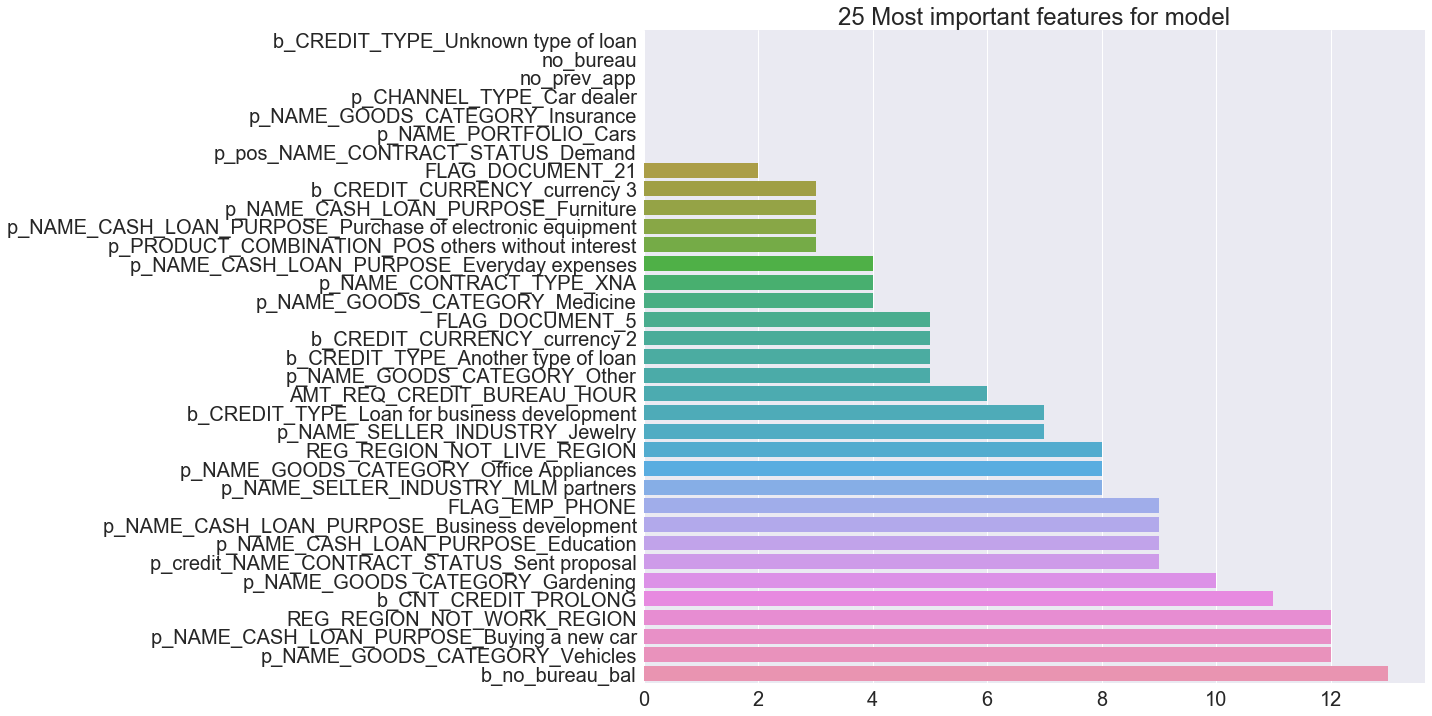

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

# Get important features
x, y = (list(x) for x in zip(*sorted(zip(model.feature_importance(), train_x.columns), 
                                                            reverse = False)))

### Styling
sns.set(font_scale=2)
plt.figure(figsize=(14, 12))
plt.title("25 Most important features for model")

# Plot important features
_ = sns.barplot(x[:35], y[:35])
# y[:35]

---
<a id="save"></a>

# [^](#toc) Save file to CSV

In [44]:
predictions = model.predict(test_x)

pd.DataFrame({
    "SK_ID_CURR": test_id,
    "TARGET": predictions
}).to_csv("../submissions/cat_merge_lump_small_counts.csv", index=False)